# High Concentration BAS Simulation

## Functions

In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import os
from datetime import datetime
import json
import plotly.graph_objects as go


In [28]:
def RebinIntensity(timeBins, counts, newDt):
    """
    RebinIntensity  Efficiently re-bin an intensity trace to a new time resolution
    
      Inputs:
        timeBins    - Original bin-center times [s]
        counts      - Photon counts per original bin
        newDt       - Desired new bin width [s]
    
      Outputs:
        newTimeBins - New bin-center times [s]
        newCounts   - Photon counts per new bin
    """

    # 1) Original bin width and span
    tOld = timeBins[1] - timeBins[0]
    tStart = timeBins[0] - tOld/2
    tEnd = timeBins[-1] + tOld/2

    # 2) Number of new bins
    duration = tEnd - tStart
    nNew = np.floor(duration / newDt).astype(int)

    # 3) Compute new bin indices for each original bin
    defIdx = np.floor((timeBins - tStart) / newDt).astype(int)
    # ensure indices are within [0, nNew-1]
    binIdx = np.clip(defIdx, 0, nNew-1)

    # 4) Sum counts into new bins (vectorized)
    newCounts = np.bincount(binIdx, weights=counts.flatten(), minlength=nNew)

    # 5) Compute new bin centers
    newTimeBins = tStart + np.arange(nNew)*newDt + newDt/2

    # 6) Plot the rebinned intensity trace
    # plt.figure()
    # plt.plot(newTimeBins, newCounts, '-')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Counts per bin')
    # plt.title('Re-binned Intensity Trace')
    # plt.grid(True)
    # plt.show()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=newTimeBins,
        y=newCounts,
        mode='lines',
        name='Counts per bin'
    ))

    fig.update_layout(
        title='Re-binned Intensity Trace',
        xaxis_title='Time (s)',
        yaxis_title='Counts per bin',
        template='simple_white',
        showlegend=False
    )

    fig.show()

    return newTimeBins, newCounts

In [29]:
def SimPhotDiffFlowGL6(C_molar, Rp, D, totalTime, binDt, w0, axialFactor, includeBg, bgRate, beamShape, vFlow, resFactor=10):
    """
    SimPhotDiffFlowGL6  Simulate photon arrivals via sweeping reservoir + reflection
    Core elements:
        - Pre-generated reservoir spanning resFactor * Lbox in x, ±Lbox in y,z
        - Advective flow + diffusion each dt-step
        - Diffusion: reflecting boundaries in excitation volume (±Lbox)
        - No births/deaths: sweeping reservoir reused via column-wise permutation
        - Photon thinning via fixed dt binning
        - Binning and preview via RebinIntensity
            This two-stage randomness
        
            Stage 1 (brightness jitter): Ri=biRp with bi drawn once from a non-Poisson distribution.
        
            Stage 2 (shot noise): photon counts in each Δt are Poisson with mean ∑RiWiΔt.
        
    Inputs:
        C_molar     - concentration [mol/L]
        Rp          - emission rate at beam center [photons/s]
        D           - diffusion coefficient [m^2/s]
        totalTime   - total simulation duration [s]
        binDt       - time bin width [s]
        w0          - lateral beam waist [m]
        axialFactor - ratio w_z/w0 (unitless)
        includeBg   - boolean: include Poisson background
        bgRate      - background rate [photons/s]
        beamShape   - 'gaussian' or 'gl'
        vFlow       - advective flow speed in x [m/s]
        resFactor   - reservoir length factor (multiples of Lbox) in x (default 10)
    Outputs:
        arrivalTimes - photon timestamps [s]
        counts       - counts per bin
        timeBins     - bin centers [s]
    """

    tic = time.time()
    # if resFactor == 10:
    #     pass
    # if vFlow == 0:
    #     pass

    # 1) Geometry & Constraints
    NA = 6.022e23                   # Avogadro (#/mol)
    C_m3 = C_molar * 1e3            # mol/L --> mol/m^3
    w_z = axialFactor * w0          # axial waist [m]
    Lbox = 5 * max(w0, w_z)         # half-box size [m]
    Lres = resFactor * Lbox         # reservoir half-length [m]


    # 2) Reservoir initialization
    area_yz = (2*Lbox)**2           # cross-section area [m^2]
    Vres = (2*Lres) * area_yz       # reservoir volume [m^3]
    Nres = max(1, np.random.poisson(C_m3 * NA * Vres))  # reservoir molecules (>=1)
    # Uniform positions in x∈[-Lres,Lres], y, z∈[-Lbox,Lbox]
    x = (np.random.rand(Nres,1)-0.5)*2*Lres
    y = (np.random.rand(Nres,1)-0.5)*2*Lbox
    z = (np.random.rand(Nres,1)-0.5)*2*Lbox
    pos = np.concatenate([x, y, z], axis=1)

    # 3) Time step and diffusion
    dt = binDt                      # timestep [s]
    sigma = np.sqrt(2 * D * dt)     # diffusion std [m]
    nSteps = np.ceil(totalTime/dt).astype(int)
    if vFlow > 0:
        stepsPerSweep = np.ceil((2*Lres) / (vFlow * dt)).astype(int)
    else:
        stepsPerSweep = float('inf')

    # 4) Preallocate photon times
    Veff = np.pi ** (3/2) * w0**2 * w_z                 # focal vol [m^3]
    Navg = C_m3 * NA * Veff         # avg in focus
    expCount = np.ceil((Navg*Rp + bgRate) * totalTime * 1.2).astype(int)
    arrivalTimes = []#np.zeros((expCount, 1))
    idx = 0

    # 4.5) Other noise effects in emission (particle brightness variation)
    # std of brightness fluctuations (e.g. 0.2 for ±20% jitter)
    sigma_b = 0.2
    #per molecule brightness factors, mean = 1
    #b = np.exp(sigma_b * np.random.randn(Nres, 1) - 0.5 * sigma_b**2)
    Rp_i = np.exp(np.random.normal(loc=np.log(Rp), scale=sigma_b, size=(Nres, 1)))


    # 5) Simulation loop
    for k in range(1, nSteps+1):
        t0 = (k-1) * dt

        # 5a) Advect reservoir in x
        pos[:, 0] = pos[:, 0] + vFlow * dt

        # 5a-ii) Periodic wrap full reservoir in x
        pos[:, 0] = np.mod(pos[:, 0] + Lres, 2*Lres) - Lres


        # 5b) Diffuse particles within excitation volume
        inBox = np.abs(pos[:, 0]) <= Lbox
        pos[inBox, :] = pos[inBox, :] + sigma * np.random.randn(np.sum(inBox), 3)

        # 5c) Reflecting boundaries for diffusion inBox
        # reflect x
        ix = inBox & (pos[:, 0] > +Lbox)
        pos[ix, 0] = 2*Lbox - pos[ix, 0]
        ix = inBox & (pos[:, 0] < -Lbox)
        pos[ix, 0] = -2 * Lbox - pos[ix, 0]
        # reflect y
        iy = inBox & (pos[:, 1] > +Lbox)
        pos[iy, 1] = 2*Lbox - pos[iy, 1]
        iy = inBox & (pos[:, 1] < -Lbox)
        pos[iy, 1] = -2*Lbox - pos[iy, 1]
        #reflect z
        iz = inBox & (pos[:, 2] > +Lbox)
        pos[iz, 2] = 2*Lbox - pos[iz, 2]
        iz = inBox & (pos[:, 2] < -Lbox)
        pos[iz, 2] = -2 * Lbox - pos[iz, 2]

        # 5d) Photon emission + background counts
        xy2 = np.power(pos[:, 0], 2) + np.power(pos[:, 1], 2)
        z2 = np.power(pos[:, 2], 2)

        if beamShape.lower() == 'gaussian':
                W = np.exp(-2 * xy2/w0**2 - 2*z2/w_z**2)
        elif beamShape.lower() == 'gl':
                Wlat = np.exp(-2*xy2/w0**2)
                Wax = 1 / (1 + z2/w_z**2)
                W = Wlat * Wax
        else:
            raise ValueError(f"Unknown beamShape: {beamShape}")
            
        # Rtot = Rp * np.sum(W)
        #Rtot = Rp * np.sum(b.flatten() * W)           # photons/s with particle brightness variation
        Rtot = np.sum(Rp_i.flatten() * W)
        Nph = np.random.poisson(Rtot * dt)
        if includeBg:
            Nbg = np.random.poisson(bgRate * dt)
        else:
            Nbg = 0
        NtotEv = Nph + Nbg
        if NtotEv > 0:
            arrivalTimes.extend((t0 + np.random.rand(NtotEv) * dt).tolist())
            #arrivalTimes[idx:idx+NtotEv, 0] = (t0 + np.random.rand(NtotEv, 1) * dt)
            idx += NtotEv

        # 5e) Permute reservoir columns every full sweep
        if np.mod(k, stepsPerSweep) == 0:
            perm = np.random.permutation(Nres)
            pos[:, 0] = pos[perm, 0]
            perm = np.random.permutation(Nres)
            pos[:, 1] = pos[perm, 1]
            perm = np.random.permutation(Nres)
            pos[:, 2] = pos[perm, 2]
    # 6) Trim arrivals
    arrivalTimes = np.array(arrivalTimes)
    arrivalTimes = arrivalTimes[:idx-1]

    # 7) Bin into intensity trace
    edges = np.arange(0, totalTime, binDt)
    counts, _ = np.histogram(arrivalTimes, bins=edges)
    timeBins = edges[:-1] + binDt/2

    # 8) Preview plot (course rebin)
    newDt = min(binDt*100, totalTime/1000)
    newDt = 0.0005

    newTimeBins, newCounts = RebinIntensity(timeBins, counts, newDt)
    toc = time.time()
    return arrivalTimes, counts, timeBins, Rp_i

## Random Sim Params

In [30]:
num_species = np.random.randint(1,4) #[1,3]
AmpS1 = np.random.randint(500, 3000)
AmpS2 = np.random.randint(AmpS1+1500, AmpS1+1500+2000)
AmpS3 = np.random.randint(AmpS2+1500, AmpS2+1500+2500)
total_conc = np.random.uniform(9e-12, 7e-11)
min_frac = 0.15

while True:
    fractions = np.random.dirichlet([1.5] * num_species)
    if np.all(fractions > min_frac):
        break

Frac1 = fractions[0]
Frac2 = fractions[1] if num_species >= 2 else 0.0
Frac3 = fractions[2] if num_species == 3 else 0.0
conc1 = Frac1 * total_conc
conc2 = Frac2 * total_conc
conc3 = Frac3 * total_conc

In [35]:
truedist1 = np.array([])
truedist2 = np.array([])
truedist3 = np.array([])
at1 = np.array([])
at2 = np.array([])
at3 = np.array([])

arrivalTimes1, counts, timeBins, Rp_i1 = SimPhotDiffFlowGL6(C_molar = conc1,
                                                     Rp = AmpS1/500e-6, 
                                                     D = 1e-12, 
                                                     totalTime = 0.1, 
                                                     binDt = 1e-6, 
                                                     w0 = 3e-7, 
                                                     axialFactor = 3, 
                                                     includeBg = True, 
                                                     bgRate = 5e3, 
                                                     beamShape = 'gl',
                                                     vFlow=5e-4)
truedist1 = Rp_i1
at1 = arrivalTimes1

if num_species >= 2:
    arrivalTimes2, counts, timeBins, Rp_i2 = SimPhotDiffFlowGL6(C_molar = conc2,
                                                        Rp = AmpS2/500e-6, 
                                                        D = 1e-12, 
                                                        totalTime = 0.1, 
                                                        binDt = 1e-6, 
                                                        w0 = 3e-7, 
                                                        axialFactor = 3, 
                                                        includeBg = False, 
                                                        bgRate = 0, 
                                                        beamShape = 'gl',
                                                        vFlow=5e-4)
    truedist2 = Rp_i2
    at2 = arrivalTimes2
if num_species == 3:
    arrivalTimes3, counts, timeBins, Rp_i3 = SimPhotDiffFlowGL6(C_molar = conc3,
                                                        Rp = AmpS3/500e-6, 
                                                        D = 1e-12, 
                                                        totalTime = 0.1, 
                                                        binDt = 1e-6, 
                                                        w0 = 3e-7, 
                                                        axialFactor = 3, 
                                                        includeBg = False, 
                                                        bgRate = 0, 
                                                        beamShape = 'gl',
                                                        vFlow=5e-4)
    truedist3 = Rp_i3
    at3 = arrivalTimes3

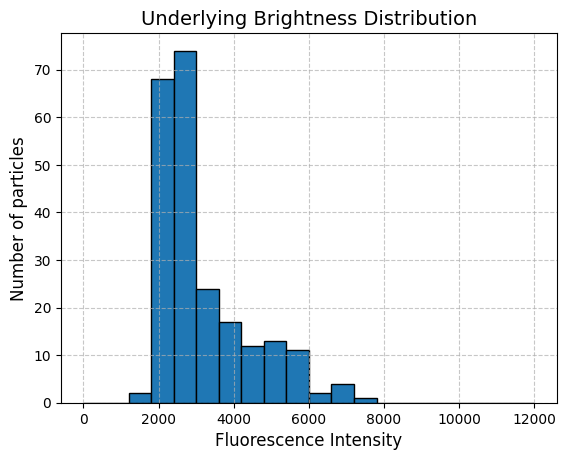

In [ ]:
fullBrightDist = np.concatenate([truedist1.flatten()*500e-6, truedist2.flatten()*500e-6, truedist3.flatten()*500e-6])
bins = np.linspace(0, 12000, 21)
truedist, bin_edges_true_dist = np.histogram(fullBrightDist, bins = bins)
plt.bar(bin_edges_true_dist[:-1], truedist, width=np.diff(bin_edges_true_dist), edgecolor='black', align='edge')
plt.title('Underlying Brightness Distribution', fontsize=14)
plt.xlabel('Fluorescence Intensity', fontsize=12)
plt.ylabel('Number of particles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

In [37]:
fullTOAs = np.concatenate([at1, at2, at3])
fullTOAs = np.sort(fullTOAs)

## Mild Preprocessing 
Generate PCH for model input

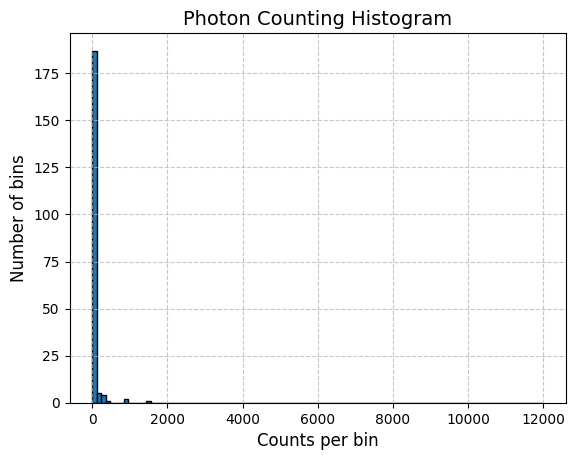

In [61]:
bins_hist = np.linspace(0, 0.1, int((0.1)/(500e-6)) + 1)
histA, edges = np.histogram(fullTOAs, bins_hist)
PCHedges = np.linspace(0, 12000, 101) 
PCHbins, _ = np.histogram(histA, bins=PCHedges)
plt.bar(PCHedges[:-1], PCHbins, width=np.diff(PCHedges), edgecolor='black', align='edge')
plt.title('Photon Counting Histogram', fontsize=14)
plt.xlabel('Counts per bin', fontsize=12)
plt.ylabel('Number of bins', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [94]:
GT = {
    "Amplitudes":{
        "AmpS1":AmpS1,
        "AmpS2":AmpS2,
        "AmpS3":AmpS3
    },
    "ActualFractions": {
        "Frac1": Frac1,
        "Frac2": Frac2,
        "Frac3": Frac3
    },
    "ActualConcentrations":{
        "Species1":conc1,
        "Species2":conc2,
        "Species3":conc3
    },
    "Extra":{
        "Concentration":total_conc
    }
}

## Save simulation files

In [288]:
data_dir = "sim_data_highconc"
os.makedirs(data_dir, exist_ok=True)
tstr = datetime.now().strftime('%d%b%y-%H%M%S')
savedir = os.path.join(data_dir, f"HCSim_{tstr}")
os.makedirs(savedir, exist_ok=True)
with open(os.path.join(savedir, f"GT.json"), 'w') as f:
    json.dump(GT, f, indent=4)
parfile = os.path.join(savedir, f"{tstr}-preparams.par")
plt.savefig(os.path.join(savedir, 'truedist.png'), dpi=300, bbox_inches='tight')
with open(parfile, 'w') as fpar:
    fpar.write('%%%% (maintain 5 header lines) \n')
    fpar.write('These data represent simulated data with up to 3 independent populations \n')
    fpar.write('This is \'high concentration\' data -- data at a concentration where diffusion is significant \n')
    fpar.write('. \n')
    fpar.write('%%%% \n\n')

    filenamedat = f"{tstr}-1"
    fpar.write(filenamedat + "\n")
    filenamedatpath = os.path.join(savedir, filenamedat)
    with open(filenamedatpath, "w") as fdata:
        fdata.write(f'{tstr}\n\n')
        fdata.write('Total acquisition time: 60 sec \n')
        fdata.write('MT Clock: 1 sec\n')
        fdata.write('Bin width for correlator intensity data: 500.00 usec \n')
        fdata.write('Scan diamater: 0.40 mm \n')
        fdata.write('Scan speed: 0.50 mm/sec \n')
        fdata.write('Lasers Active: 488 @ 0.050 mW \n')
        fdata.write('Laser modulation not active \n')
        fdata.write('Notes: \n')
        fdata.write('Simulated data\n')
        fdata.write('***end header*** \n\n')
        fdata.write('I_A\n')

        for row in fullTOAs:
            fdata.write(f"{row:.17e}\n")

with open(parfile, 'a') as fpar:
    fpar.write("\n")
    fpar.write("datatype TotTime MTclock bintime driftwinA driftwinB driftwinC threshA threshB threshC corrt dofit colA colB colC\n")
    formatSpec = '%d %f %.2e %.6f %d %d %d %d %d %d %.3f %d %d %d %d\n'
    fpar.write(formatSpec % (1, 0.1, 1, 0.000500, 0, 0, 0, 1, 1, 1, 0.003, 0, 1, 0, 0))


<Figure size 640x480 with 0 Axes>

## Save for MATLAB FCS Autocorrelation
run `load('arrivalTimes.mat')` in MATLAB terminal

then, run `FCSParams`

last, run `InteractiveFCSArrivalPlot_flow(arrivalTimes, w0, 3)`

In [ ]:
savemat(os.path.join("MATLAB_originals", "arrivalTimes.mat"), {"arrivalTimes": fullTOAs.reshape(-1, 1)})